# TorchVision Instance Segmentation Finetuning Tutorial

For this tutorial, we will be finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model in the [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/). It contains 170 images with 345 instances of pedestrians, and we will use it to illustrate how to use the new features in torchvision in order to train an instance segmentation model on a custom dataset.

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-yea_ho87
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-yea_ho87
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=265179 sha256=be3088b99c6007ec2df86342c9b168407194062c616f221a1ffe7d3b37b032c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-vy1hnzea/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import matplotlib.pyplot as plt

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [ ]:

dataset = PennFudanDataset('/content/drive/MyDrive/Colab_Notebooks/cell')


# dataset = PennFudanDataset('./PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=1225x914 at 0x7F3426FEAD90>,
 {'boxes': tensor([[  73.,  781.,   84.,  809.],
          [ 810.,  848.,  829.,  868.],
          [ 841.,  317.,  864.,  341.],
          ...,
          [  98.,  365.,  129.,  394.],
          [ 788.,  911.,  800.,  913.],
          [1169.,  375., 1193.,  398.]]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2
#git checkout v0.13.1

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    size, padding = 700, 50
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
        #transforms.append(T.RandomVerticalFlip(0.5))
        #transforms.append(T.RandomZoomOut(0.5))
        transforms.append(T.RandomIoUCrop(0.5))
        #transforms.append(T.RandomCrop(size, padding))
        #transforms.append(T.RandomRotation(degrees=(0, 180)))
        #transforms.append(T.RandomPerspective(distortion_scale=0.6, p=1.0))
    return T.Compose(transforms)

#### Testing forward() method 

Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.


In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('/content/drive/MyDrive/Colab_Notebooks/cell', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions



AttributeError: ignored

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('/content/drive/MyDrive/Colab_Notebooks/cell', get_transform(train=True))
dataset_test = PennFudanDataset('/content/drive/MyDrive/Colab_Notebooks/cell', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-15])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-15:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(

    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

cuda


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 15

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/32]  eta: 0:11:08  lr: 0.000166  loss: 9.9207 (9.9207)  loss_classifier: 0.6523 (0.6523)  loss_box_reg: 0.4053 (0.4053)  loss_mask: 2.3580 (2.3580)  loss_objectness: 6.0308 (6.0308)  loss_rpn_box_reg: 0.4743 (0.4743)  time: 20.8773  data: 11.8681  max mem: 9968
Epoch: [0]  [10/32]  eta: 0:00:55  lr: 0.001777  loss: 2.2155 (3.5720)  loss_classifier: 0.5756 (0.5616)  loss_box_reg: 0.8593 (0.7729)  loss_mask: 0.6494 (0.9635)  loss_objectness: 0.2275 (1.1425)  loss_rpn_box_reg: 0.0589 (0.1315)  time: 2.5261  data: 1.1240  max mem: 9968
Epoch: [0]  [20/32]  eta: 0:00:26  lr: 0.003389  loss: 1.5954 (2.4731)  loss_classifier: 0.3622 (0.4119)  loss_box_reg: 0.6494 (0.6588)  loss_mask: 0.4195 (0.6389)  loss_objectness: 0.1316 (0.6519)  loss_rpn_box_reg: 0.0609 (0.1117)  time: 1.2565  data: 0.5554  max mem: 10146
Epoch: [0]  [30/32]  eta: 0:00:03  lr: 0.005000  loss: 0.8707 (1.9152)  loss_classifier: 0.1687 (0.3249)  loss_box_reg: 0.4104 (0.5569)  loss_mask: 0.1933 (0.4840)  loss

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
# pick one image from the test set
img, _ = dataset_test[11]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [ ]:
prediction

[{'boxes': tensor([[7.2063e+02, 8.5275e+02, 7.9360e+02, 9.3409e+02],
          [6.0690e+02, 7.0019e+02, 6.9628e+02, 7.7974e+02],
          [1.0558e+02, 1.8492e+02, 1.9960e+02, 2.8864e+02],
          [4.4428e+01, 7.6055e+02, 1.0727e+02, 8.3798e+02],
          [4.5481e+02, 7.7649e+02, 5.5398e+02, 8.6151e+02],
          [4.8670e+02, 1.9654e-01, 5.5660e+02, 7.2833e+01],
          [9.9148e+02, 9.1070e+02, 1.0746e+03, 1.0017e+03],
          [4.5586e+00, 8.6271e+02, 6.3204e+01, 9.3394e+02],
          [3.3295e+02, 7.1597e+02, 4.0593e+02, 7.9057e+02],
          [1.1167e+00, 5.8209e+02, 4.3439e+01, 6.6118e+02],
          [4.7914e+02, 4.2800e+02, 5.5280e+02, 5.2794e+02],
          [9.1102e+02, 4.1859e+01, 9.8713e+02, 1.2590e+02],
          [1.0033e+02, 9.2902e+02, 1.7194e+02, 1.0006e+03],
          [2.4198e+02, 6.4101e+02, 3.1040e+02, 7.1586e+02],
          [7.9147e+02, 8.9034e+01, 8.7040e+02, 1.6837e+02],
          [9.8742e+02, 7.2653e+02, 1.0637e+03, 7.9537e+02],
          [7.8021e+02, 1.8896e+

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

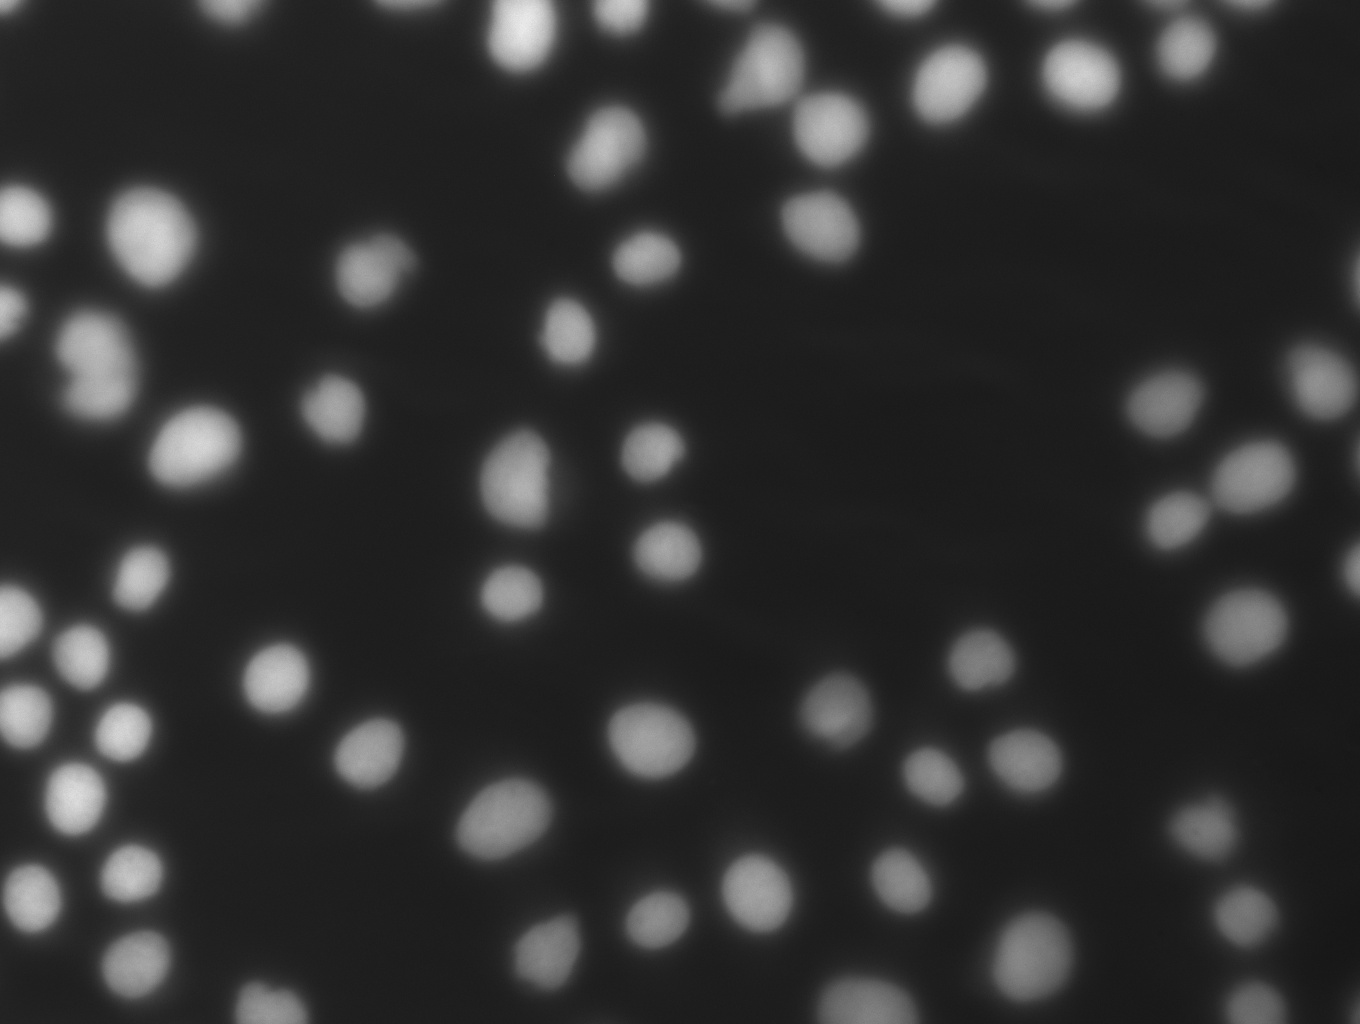

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

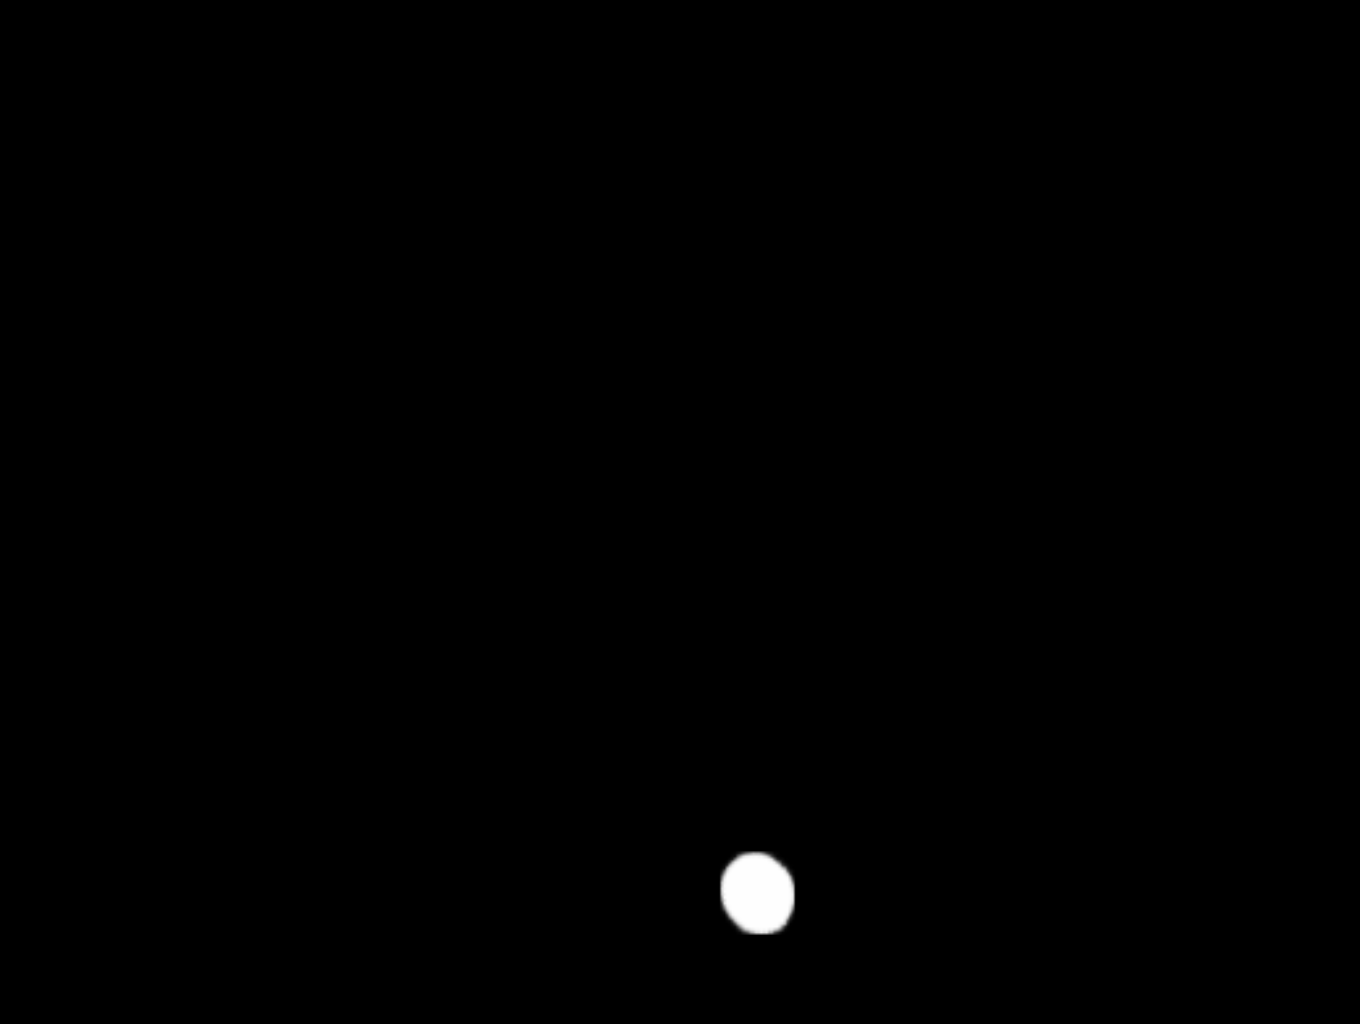

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

Looks pretty good!

## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for instance segmentation models, on a custom dataset.
For that, you wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-gpu training, check `references/detection/train.py`, which is present in the [torchvision GitHub repo](https://github.com/pytorch/vision/tree/v0.8.2/references/detection). 



In [ ]:
PATH = "entire_model.pt"

# Save
torch.save(model, PATH)
torch.save(model, '/content/drive/MyDrive/Colab_Notebooks/cell/obj_det_model.pt')

In [ ]:
len(data_loader_test)

15

In [ ]:
mod = torch.load(PATH)

In [ ]:
img, _ = dataset_test[12]

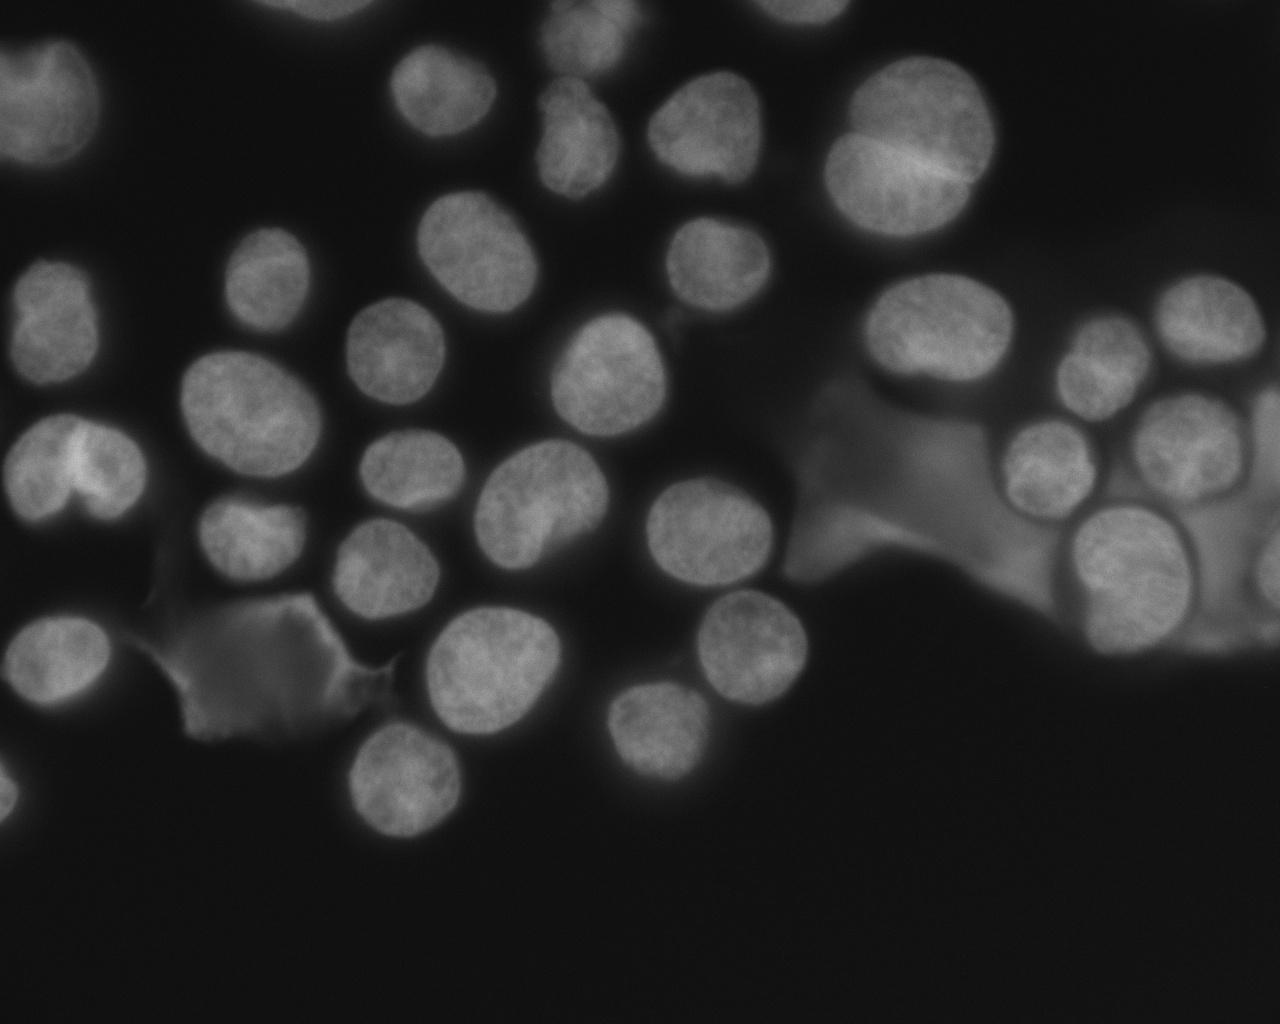

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
mod.eval()
with torch.no_grad():
    prediction = mod([img.to(device)])

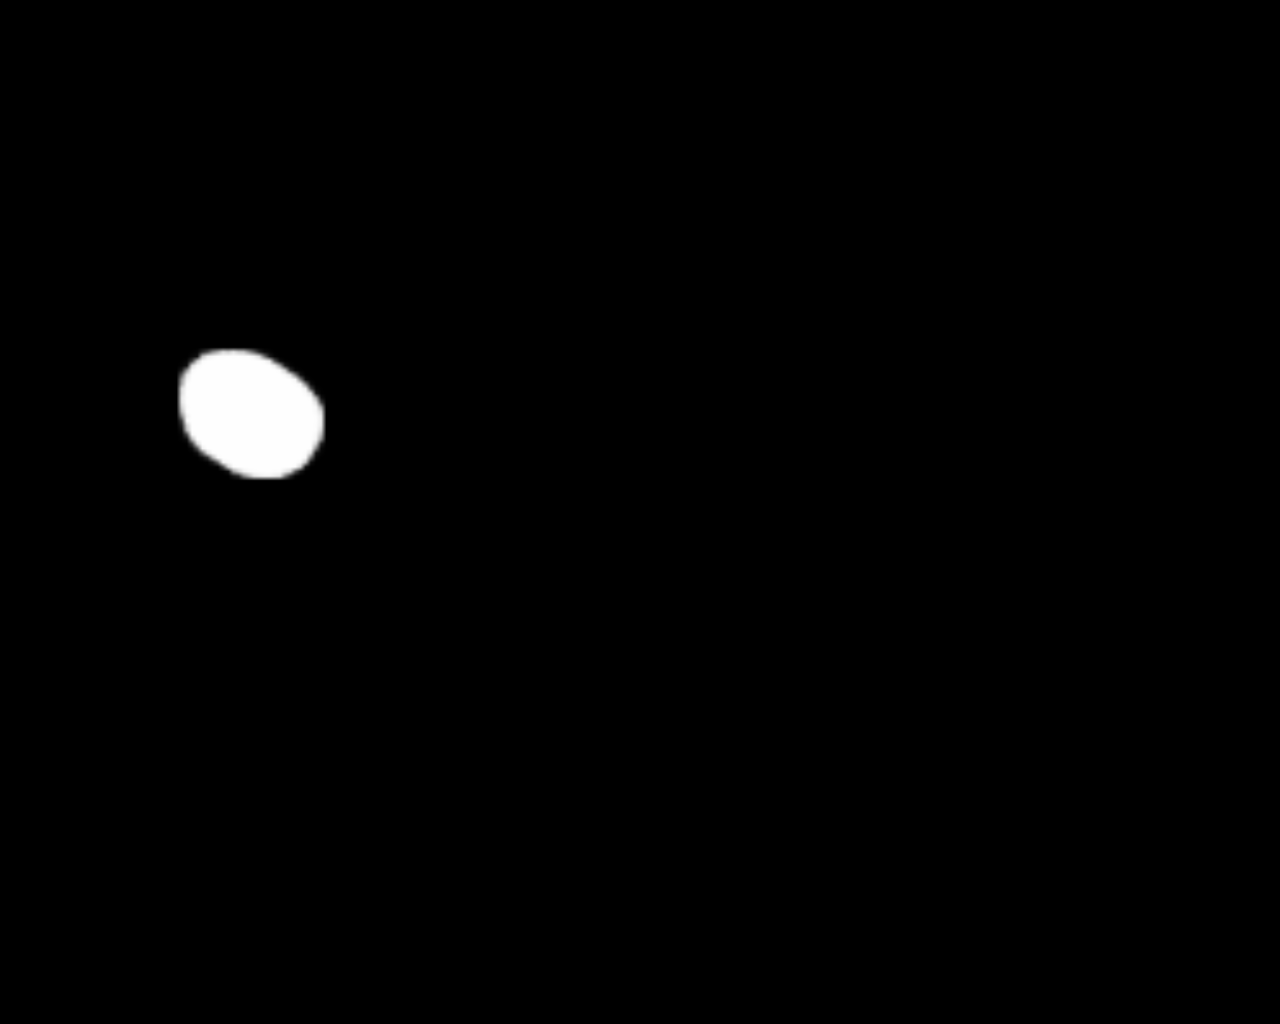

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [ ]:
model = model.to(device)
dummy_input = torch.randn(10, 3, 224, 224, device=device)
dummy_input = dummy_input.to(device)

In [ ]:
#torch.onnx.export(model, dummy_input, "faster_rcnn.onnx", opset_version = 11)
torch.onnx.export(model, dummy_input,  '/content/drive/MyDrive/Colab_Notebooks/cell/obj_det.onnx', opset_version = 11)

RuntimeError: ignored

In [ ]:
PATH = '/content/drive/MyDrive/Colab_Notebooks/cell/obj_det_path.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
!pip install onnx2torch

#conda install -c conda-forge onnx2torch

In [ ]:
import torch
from onnx2torch import convert

# Path to ONNX model
onnx_model_path = '/some/path/mobile_net_v2.onnx'
# You can pass the path to the onnx model to convert it or...
torch_model_1 = convert(onnx_model_path)

# Or you can load a regular onnx model and pass it to the converter
onnx_model = onnx.load(onnx_model_path)
torch_model_2 = convert(onnx_model)

In [ ]:
import onnxruntime as ort
# Create example data
x = torch.ones((1, 2, 224, 224)).cuda()

out_torch = torch_model_1(x)

ort_sess = ort.InferenceSession(onnx_model_path)
outputs_ort = ort_sess.run(None, {'input': x.numpy()})

# Check the Onnx output against PyTorch
print(torch.max(torch.abs(outputs_ort - out_torch.detach().numpy())))
print(np.allclose(outputs_ort, out_torch.detach().numpy(), atol=1.e-7))